# Import libraries

In [7]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Input
The feature file ucberkeley hate speech is collected from HuggingFace library.

## Dataset

In [5]:
import datasets
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'utf-8')   
df = dataset['train'].to_pandas()
df.head(1)

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,text,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,annotator_gender,annotator_trans,annotator_educ,annotator_income,annotator_ideology,annotator_gender_men,annotator_gender_women,annotator_gender_non_binary,annotator_gender_prefer_not_to_say,annotator_gender_self_describe,annotator_transgender,annotator_cisgender,annotator_transgender_prefer_not_to_say,annotator_education_some_high_school,annotator_education_high_school_grad,annotator_education_some_college,annotator_education_college_grad_aa,annotator_education_college_grad_ba,annotator_education_professional_degree,annotator_education_masters,annotator_education_phd,annotator_income_<10k,annotator_income_10k-50k,annotator_income_50k-100k,annotator_income_100k-200k,annotator_income_>200k,annotator_ideology_extremeley_conservative,annotator_ideology_conservative,annotator_ideology_slightly_conservative,annotator_ideology_neutral,annotator_ideology_slightly_liberal,annotator_ideology_liberal,annotator_ideology_extremeley_liberal,annotator_ideology_no_opinion,annotator_race_asian,annotator_race_black,annotator_race_latinx,annotator_race_middle_eastern,annotator_race_native_american,annotator_race_pacific_islander,annotator_race_white,annotator_race_other,annotator_age,annotator_religion_atheist,annotator_religion_buddhist,annotator_religion_christian,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-3.9,Yes indeed. She sort of reminds me of the elde...,0.81,1.88,0.36,0.34,1.35,1.23,-1.130178,True,True,True,True,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,male,no,college_grad_ba,<10k,neutral,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,25.0,False,False,True,False,False,False,False,False,False,False,False,True,False


In [9]:
text_column = 'text'
target_column = 'labels'

# https://stackoverflow.com/questions/8689795/how-can-i-remove-non-ascii-characters-but-leave-periods-and-spaces
# Make sure all comment_text values are strings
dataset.loc[:, text_column] = dataset[text_column].astype(str) 
dataset.loc[:, target_column] = dataset['hatespeech'].astype(int)
dataset = dataset[dataset[target_column] != 1]
dataset.loc[:, target_column]  =dataset[target_column].map({0:0, 2:1})

C:\Users\khair\AppData\Local\Temp\ipykernel_7156\1406894199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, target_column]  =dataset[target_column].map({0:0, 2:1})


### Target subgroups

In [10]:
# ['target_gender_men', 'target_gender_non_binary', 'target_gender_transgender_men', 'target_gender_transgender_unspecified', 
# 'target_gender_transgender_women', 'target_gender_women', 'target_gender_other', 'target_gender']
genders = [col for col in dataset.columns if 'target_gender' in col]
print(genders)

# ['target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 
# 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race']
races = [col for col in dataset.columns if 'target_race' in col]
print(races)

['target_gender_men', 'target_gender_non_binary', 'target_gender_transgender_men', 'target_gender_transgender_unspecified', 'target_gender_transgender_women', 'target_gender_women', 'target_gender_other', 'target_gender']
['target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race']


In [64]:
genders = ['target_gender_men', 'target_gender_women', 'target_gender_transgender_men', 'target_gender_transgender_women']
races = ['target_race_asian', 'target_race_black','target_race_white']

### Aggregate and drop duplicates

In [20]:
%%time
id_columns = ['comment_id']
target_annotated_columns = [col for col in dataset.columns if 'target_' in col]
grouped = dataset.groupby(id_columns)[target_annotated_columns].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
dataset_unique = dataset.drop_duplicates(subset=id_columns)
dataset_unique = grouped.merge(dataset_unique[id_columns+[text_column]], on=id_columns, how='inner').reset_index(drop=True)
dataset_unique.head(2)

,comment_id,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_race_other,target_race,target_religion_atheist,target_religion_buddhist,target_religion_christian,target_religion_hindu,target_religion_jewish,target_religion_mormon,target_religion_muslim,target_religion_other,target_religion,target_origin_immigrant,target_origin_migrant_worker,target_origin_specific_country,target_origin_undocumented,target_origin_other,target_origin,target_gender_men,target_gender_non_binary,target_gender_transgender_men,target_gender_transgender_unspecified,target_gender_transgender_women,target_gender_women,target_gender_other,target_gender,target_sexuality_bisexual,target_sexuality_gay,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_sexuality,target_age_children,target_age_teenagers,target_age_young_adults,target_age_middle_aged,target_age_seniors,target_age_other,target_age,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other,target_disability,text
0,1,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,White people are trash.
1,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,"You've caught the big gay, it's known to be airborne via dildos."


## Result

In [29]:
results_root = '../../models/uc berkeley/bert base uncased/'
dp_results_root = '../../dp models/uc berkeley/bert base/0.45/'

result = pd.read_csv(results_root + 'results.csv')
result.rename({'id':'comment_id'}, axis=1, inplace=True)

result_dp = pd.read_csv(dp_results_root + 'results.csv')
result_dp.rename({'id':'comment_id'}, axis=1, inplace=True)

### Preprocess

In [24]:
merged = result.merge(dataset_unique, on=id_columns, how='inner').reset_index(drop=True)
print(merged.shape)

(38564, 58)


In [31]:
merged_dp = result_dp.merge(dataset_unique, on=id_columns, how='inner').reset_index(drop=True)
print(merged_dp.shape)

(38564, 58)


# Binarize for target group

In [66]:
subgroup_type='Gender'
identity_columns = genders

In [33]:
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in [target_column] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

In [67]:
merged = convert_dataframe_to_bool(merged)
merged_dp = convert_dataframe_to_bool(merged_dp)

In [35]:
merged.groupby(['split'])[[target_column]].value_counts()

split       labels
test        False      4452
            True       1333
train       False     20655
            True       6339
validation  False      4411
            True       1374
dtype: int64

# Performance

## Metric utils
Implementation is collected from the [Jigsaw competition notebook](https://www.kaggle.com/code/dborkan/benchmark-kernel).
Descriptions are available at the [competition evaluation tab](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation).

In [39]:
from sklearn import metrics

SUBGROUP_F1 = 'subgroup_f1'
SUBGROUP_ACCURACY = 'subgroup_accuracy'
SUBGROUP_AUC = 'subgroup_auc'
SUBGROUP_FPR = 'subgroup_fpr'
SUBGROUP_TPR = 'subgroup_tpr'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

# https://en.wikipedia.org/wiki/False_positive_rate

def calculate_FPR(df, label, model_name):
    y_pred = df[model_name]>=0.5
    false_positives = df[(y_pred) & (~df[label])].shape[0]
    negatives = df[~df[label]].shape[0]

    if negatives == 0:
        print("FPR is undefined. No negative examples found!")
        return np.nan
        
    return false_positives/negatives

def calculate_TPR(df, label, model_name):
    y_pred = df[model_name]>=0.5
    true_positives = df[(y_pred) & (df[label])].shape[0]
    positives = df[df[label]].shape[0]

    if positives == 0:
        print("TPR is undefined. No positive examples found!")
        return np.nan
        
    return true_positives/positives

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        subset = dataset[dataset[subgroup]]
        y_true, y_prob, y_pred = subset[label_col], subset[model], subset[model]>=0.5

        record[SUBGROUP_F1] = metrics.f1_score(y_true, y_pred)
        record[SUBGROUP_ACCURACY] = metrics.accuracy_score(y_true, y_pred)
        record[SUBGROUP_AUC] = metrics.roc_auc_score(y_true, y_prob)

        # https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        record[SUBGROUP_FPR] = calculate_FPR(subset, label_col, model)
        record[SUBGROUP_TPR] = calculate_TPR(subset, label_col, model)
        
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records)

def calculate_overall_auc(df, model_name):
    true_labels = df[target_column]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [40]:
def performance(df, split_type='test', prediction_column='probs'):
    df = df[df['split']==split_type]

    bias_metrics_df = compute_bias_metrics_for_model(
        df, identity_columns, prediction_column, target_column
    )
    
    y_preds = df[prediction_column]>=0.5
    acc = metrics.accuracy_score(df[target_column], y_preds)
    f1 = metrics.f1_score(df[target_column], y_preds)
    precision = metrics.precision_score(df[target_column], y_preds)
    recall = metrics.recall_score(df[target_column], y_preds)

    auc = metrics.roc_auc_score(df[target_column], df[prediction_column])

    final_bias = get_final_metric(bias_metrics_df, auc)
    final_fpr = calculate_FPR(df, target_column, prediction_column)
    final_tpr = calculate_TPR(df, target_column, prediction_column)

    TPED = abs(final_tpr - bias_metrics_df[SUBGROUP_TPR]).sum()
    FPED = abs(final_fpr - bias_metrics_df[SUBGROUP_FPR]).sum()

    print(f'Accuracy {np.round(acc, 4)}, AUC {np.round(auc, 4)}, TPR {np.round(final_tpr, 4)}, FPR {np.round(final_fpr, 4)}.')
    print(f'F1 {np.round(f1,4)}, Precision {np.round(precision,4)}, Recall {np.round(recall,4)}')
    print(f'Final bias {np.round(final_bias, 4)}. Eodds {np.round(TPED+FPED, 4)}, TPED {np.round(TPED, 4)}, FPED {np.round(FPED, 4)}.')
    
    return bias_metrics_df

## Normal

### Train

In [41]:
train_bias_metrics_df = performance(merged, 'train')
train_bias_metrics_df

Accuracy 0.8155, AUC 0.9177, TPR 0.873, FPR 0.2021.
F1 0.6897, Precision 0.57, Recall 0.873
Final bias 0.9162. Eodds 0.3984, TPED 0.236, FPED 0.1623.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_race_asian,712,0.720648,0.903090,0.945238,0.070470,0.767241,0.968313,0.868788
1,target_race_black,3085,0.836008,0.847650,0.935520,0.216261,0.938136,0.878098,0.961906
2,target_race_white,1711,0.657388,0.812975,0.899542,0.185575,0.807895,0.928372,0.887919


In [68]:
train_bias_metrics_df = performance(merged, 'train')
train_bias_metrics_df

Accuracy 0.8155, AUC 0.9177, TPR 0.873, FPR 0.2021.
F1 0.6897, Precision 0.57, Recall 0.873
Final bias 0.9109. Eodds 0.5898, TPED 0.2556, FPED 0.3342.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_gender_men,2232,0.599469,0.797043,0.886880,0.207485,0.816867,0.919530,0.889091
1,target_gender_women,6118,0.655275,0.752697,0.870531,0.291816,0.873633,0.891858,0.917367
2,target_gender_transgender_men,335,0.705882,0.895522,0.940519,0.085106,0.792453,0.961305,0.875250
3,target_gender_transgender_women,253,0.733945,0.885375,0.943962,0.080000,0.754717,0.964453,0.872760


### Test

In [42]:
test_bias_metrics_df = performance(merged, 'test')
test_bias_metrics_df

Accuracy 0.7846, AUC 0.8732, TPR 0.7929, FPR 0.2179.
F1 0.6292, Precision 0.5215, Recall 0.7929
Final bias 0.868. Eodds 0.5404, TPED 0.3709, FPED 0.1694.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_race_asian,149,0.603774,0.859060,0.900250,0.089431,0.615385,0.938088,0.801153
1,target_race_black,634,0.809605,0.824921,0.906464,0.230563,0.904215,0.830929,0.935988
2,target_race_white,352,0.611399,0.786932,0.836073,0.189591,0.710843,0.881576,0.827869


In [69]:
test_bias_metrics_df = performance(merged, 'test')
test_bias_metrics_df

Accuracy 0.7846, AUC 0.8732, TPR 0.7929, FPR 0.2179.
F1 0.6292, Precision 0.5215, Recall 0.7929
Final bias 0.8569. Eodds 0.8521, TPED 0.4715, FPED 0.3806.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_gender_men,421,0.471154,0.738717,0.774288,0.247126,0.671233,0.856762,0.806527
1,target_gender_women,1279,0.639175,0.726349,0.825252,0.315265,0.826667,0.830435,0.887845
2,target_gender_transgender_men,75,0.500000,0.866667,0.900673,0.090909,0.555556,0.944601,0.784643
3,target_gender_transgender_women,51,0.625000,0.882353,0.928571,0.090909,0.714286,0.937680,0.848879


## Differential Private

### Train

In [43]:
train_dp_bias_metrics_df = performance(merged_dp, 'train')
train_dp_bias_metrics_df

Accuracy 0.8133, AUC 0.8636, TPR 0.7066, FPR 0.1539.
F1 0.64, Precision 0.5849, Recall 0.7066
Final bias 0.8552. Eodds 0.5604, TPED 0.4123, FPED 0.1481.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_race_asian,712,0.616822,0.884831,0.881842,0.053691,0.568966,0.929890,0.792789
1,target_race_black,3085,0.815328,0.835981,0.900083,0.191372,0.874706,0.807902,0.937801
2,target_race_white,1711,0.570713,0.799532,0.815466,0.143501,0.600000,0.866310,0.817196


In [70]:
train_dp_bias_metrics_df = performance(merged_dp, 'train')
train_dp_bias_metrics_df

Accuracy 0.8133, AUC 0.8636, TPR 0.7066, FPR 0.1539.
F1 0.64, Precision 0.5849, Recall 0.7066
Final bias 0.8537. Eodds 0.7265, TPED 0.4485, FPED 0.278.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_gender_men,2232,0.539745,0.789875,0.822927,0.181068,0.662651,0.844528,0.848426
1,target_gender_women,6118,0.607932,0.744688,0.813955,0.252013,0.735723,0.813133,0.884411
2,target_gender_transgender_men,335,0.533333,0.853731,0.885320,0.085106,0.528302,0.918050,0.810411
3,target_gender_transgender_women,253,0.574468,0.841897,0.895943,0.070000,0.509434,0.928253,0.804612


### Test

In [44]:
test_dp_bias_metrics_df = performance(merged_dp, 'test')
test_dp_bias_metrics_df

Accuracy 0.8154, AUC 0.8606, TPR 0.6924, FPR 0.1478.
F1 0.6335, Precision 0.5838, Recall 0.6924
Final bias 0.8493. Eodds 0.6697, TPED 0.5208, FPED 0.1489.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_race_asian,149,0.500000,0.852349,0.875235,0.056911,0.423077,0.923819,0.771630
1,target_race_black,634,0.817360,0.840694,0.888745,0.176944,0.865900,0.802484,0.936404
2,target_race_white,352,0.614458,0.818182,0.814485,0.118959,0.614458,0.865439,0.815331


In [71]:
test_dp_bias_metrics_df = performance(merged_dp, 'test')
test_dp_bias_metrics_df

Accuracy 0.8154, AUC 0.8606, TPR 0.6924, FPR 0.1478.
F1 0.6335, Precision 0.5838, Recall 0.6924
Final bias 0.846. Eodds 0.9576, TPED 0.6076, FPED 0.35.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,target_gender_men,421,0.466321,0.755344,0.775587,0.215517,0.616438,0.824644,0.829229
1,target_gender_women,1279,0.625561,0.738858,0.807513,0.263274,0.744000,0.797457,0.889313
2,target_gender_transgender_men,75,0.375000,0.866667,0.904040,0.060606,0.333333,0.931784,0.787037
3,target_gender_transgender_women,51,0.571429,0.882353,0.912338,0.068182,0.571429,0.932075,0.821898


In [45]:
diff = test_bias_metrics_df.drop(columns=['subgroup']) - test_dp_bias_metrics_df.drop(columns=['subgroup'])
diff['subgroup'] = test_bias_metrics_df['subgroup']
diff

,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc,subgroup
0,0,0.103774,0.006711,0.025016,0.032520,0.192308,0.014270,0.029524,target_race_asian
1,0,-0.007754,-0.015773,0.017719,0.053619,0.038314,0.028445,-0.000416,target_race_black
2,0,-0.003059,-0.031250,0.021588,0.070632,0.096386,0.016137,0.012538,target_race_white


# Plot
https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [52]:
def plot_metric(plot_df, ylabel, subgroup_type='gender',metric='AUC'):
    # plot grouped bar chart
    ax = plot_df.plot(
            x='Identity',
            kind='bar',
            stacked=False,
            # title='Bias (FPR) evaluation on Jigsaw',
            figsize=(14, 6),
            rot=0
    )

    ax.set_xlabel('Identity')
    ax.set_ylabel(ylabel)
    ax.legend(loc=1)
    plt.savefig(os.path.join(results_root, f'{subgroup_type}_{metric}_plot.pdf'))

## Count

                          Identity  Train  Test
0                target_gender_men   2232   421
1              target_gender_women   6118  1279
2    target_gender_transgender_men    335    75
3  target_gender_transgender_women    253    51


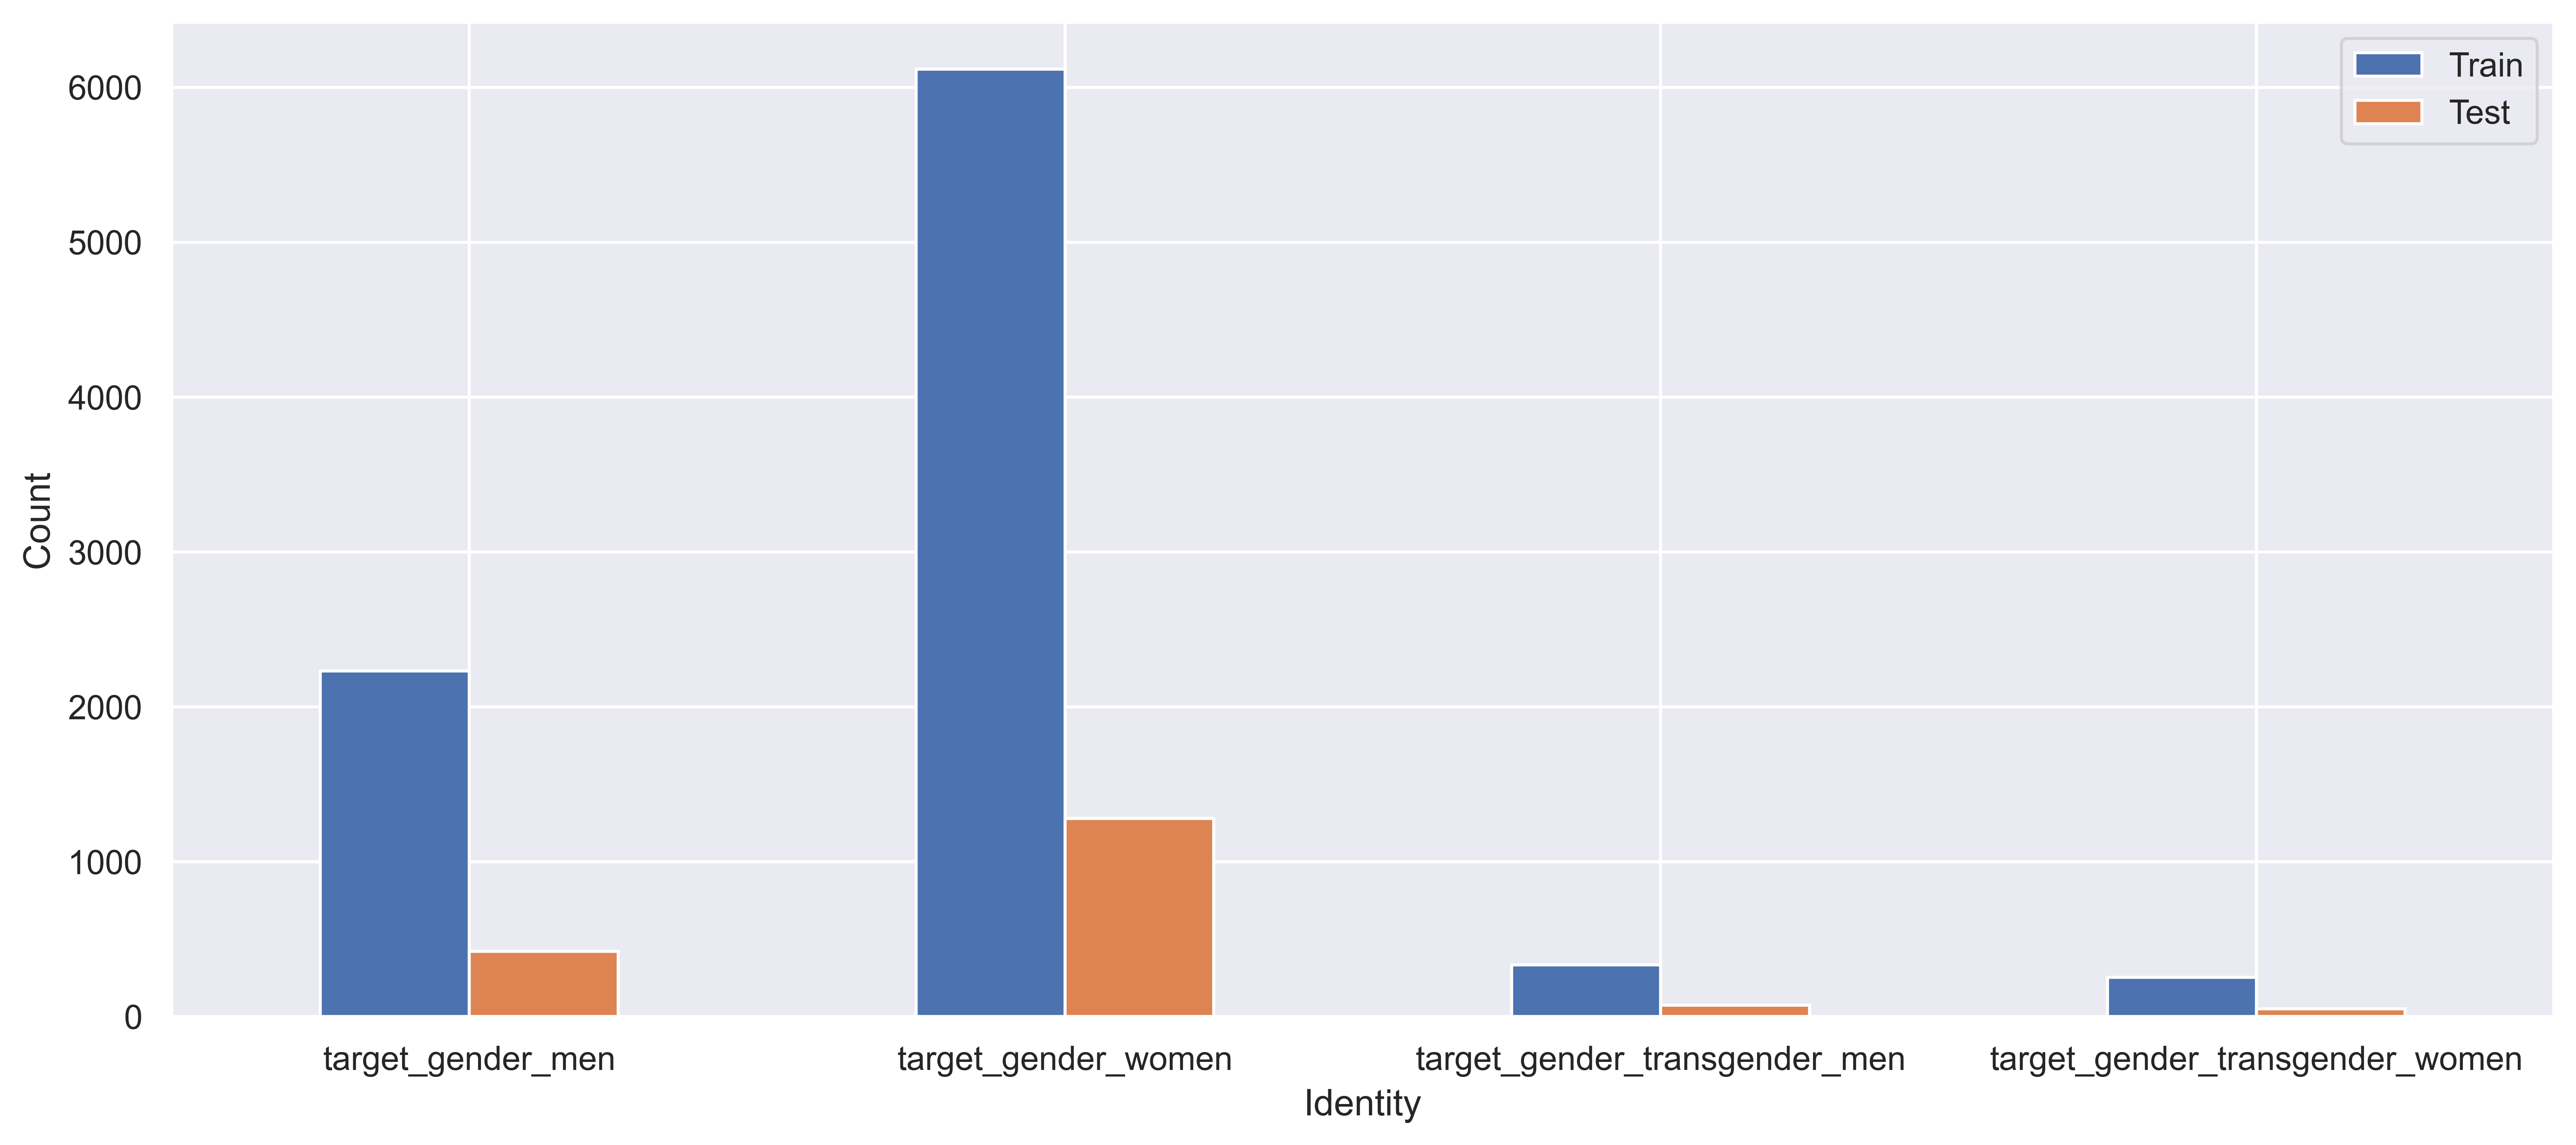

In [72]:
count_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df['subgroup_size'],
        'Test': test_bias_metrics_df['subgroup_size']
    }
)
print(count_df)
plot_metric(count_df, "Count", subgroup_type,metric='count')

## AUC

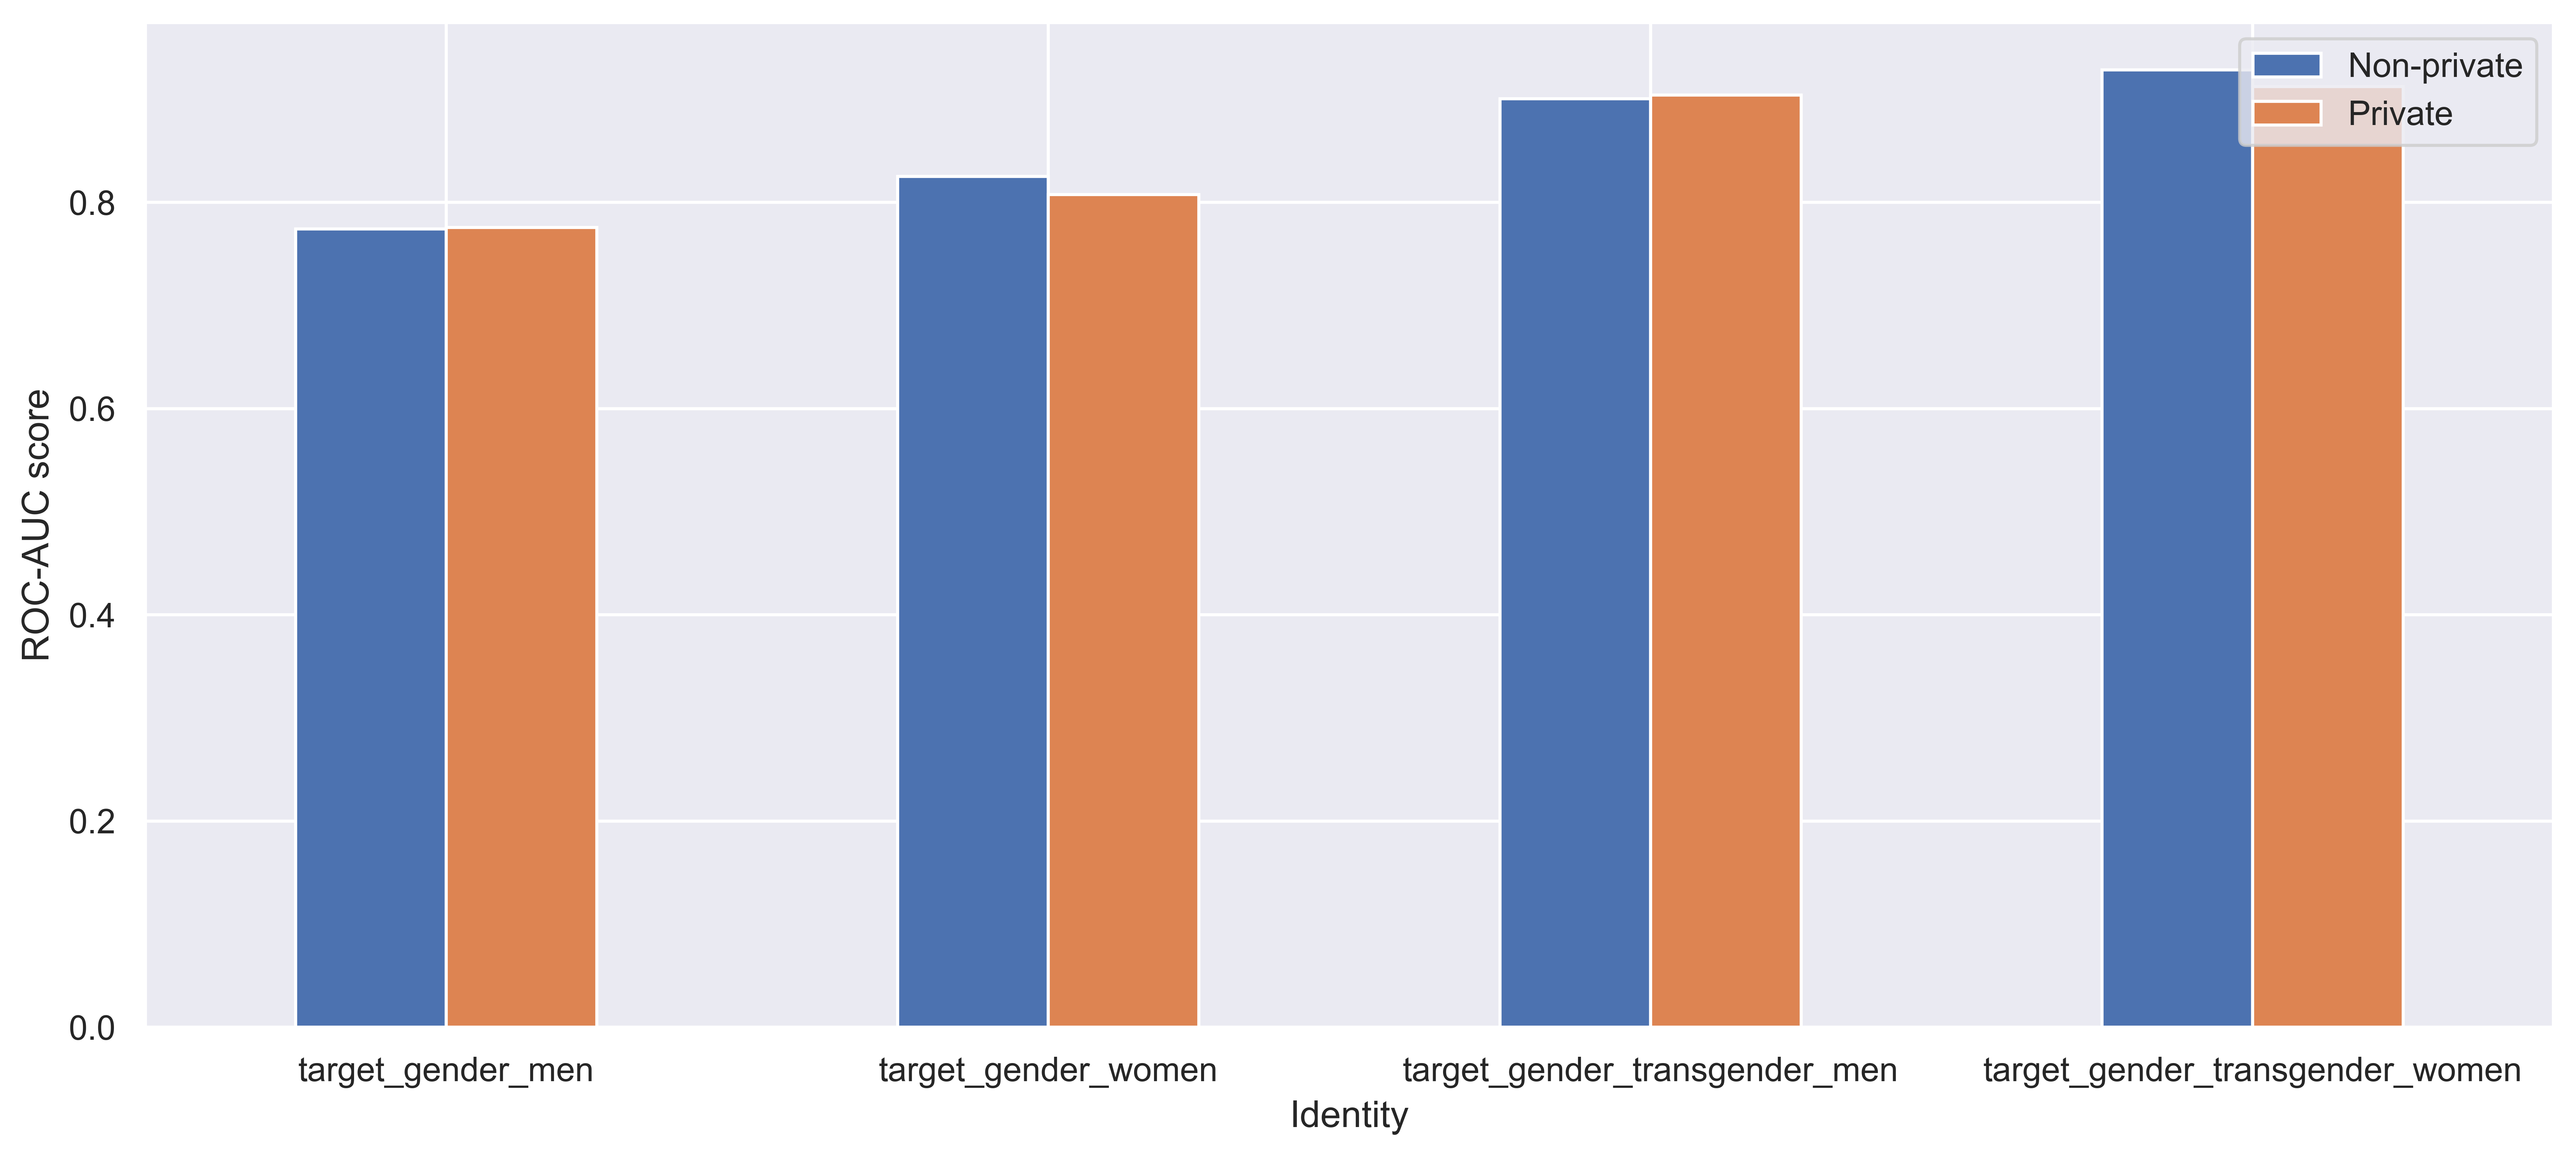

In [73]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_AUC],
        'Private': test_dp_bias_metrics_df[SUBGROUP_AUC]
    }
)
plot_metric(plot_df, "ROC-AUC score", subgroup_type,metric='AUC')

## F1-score

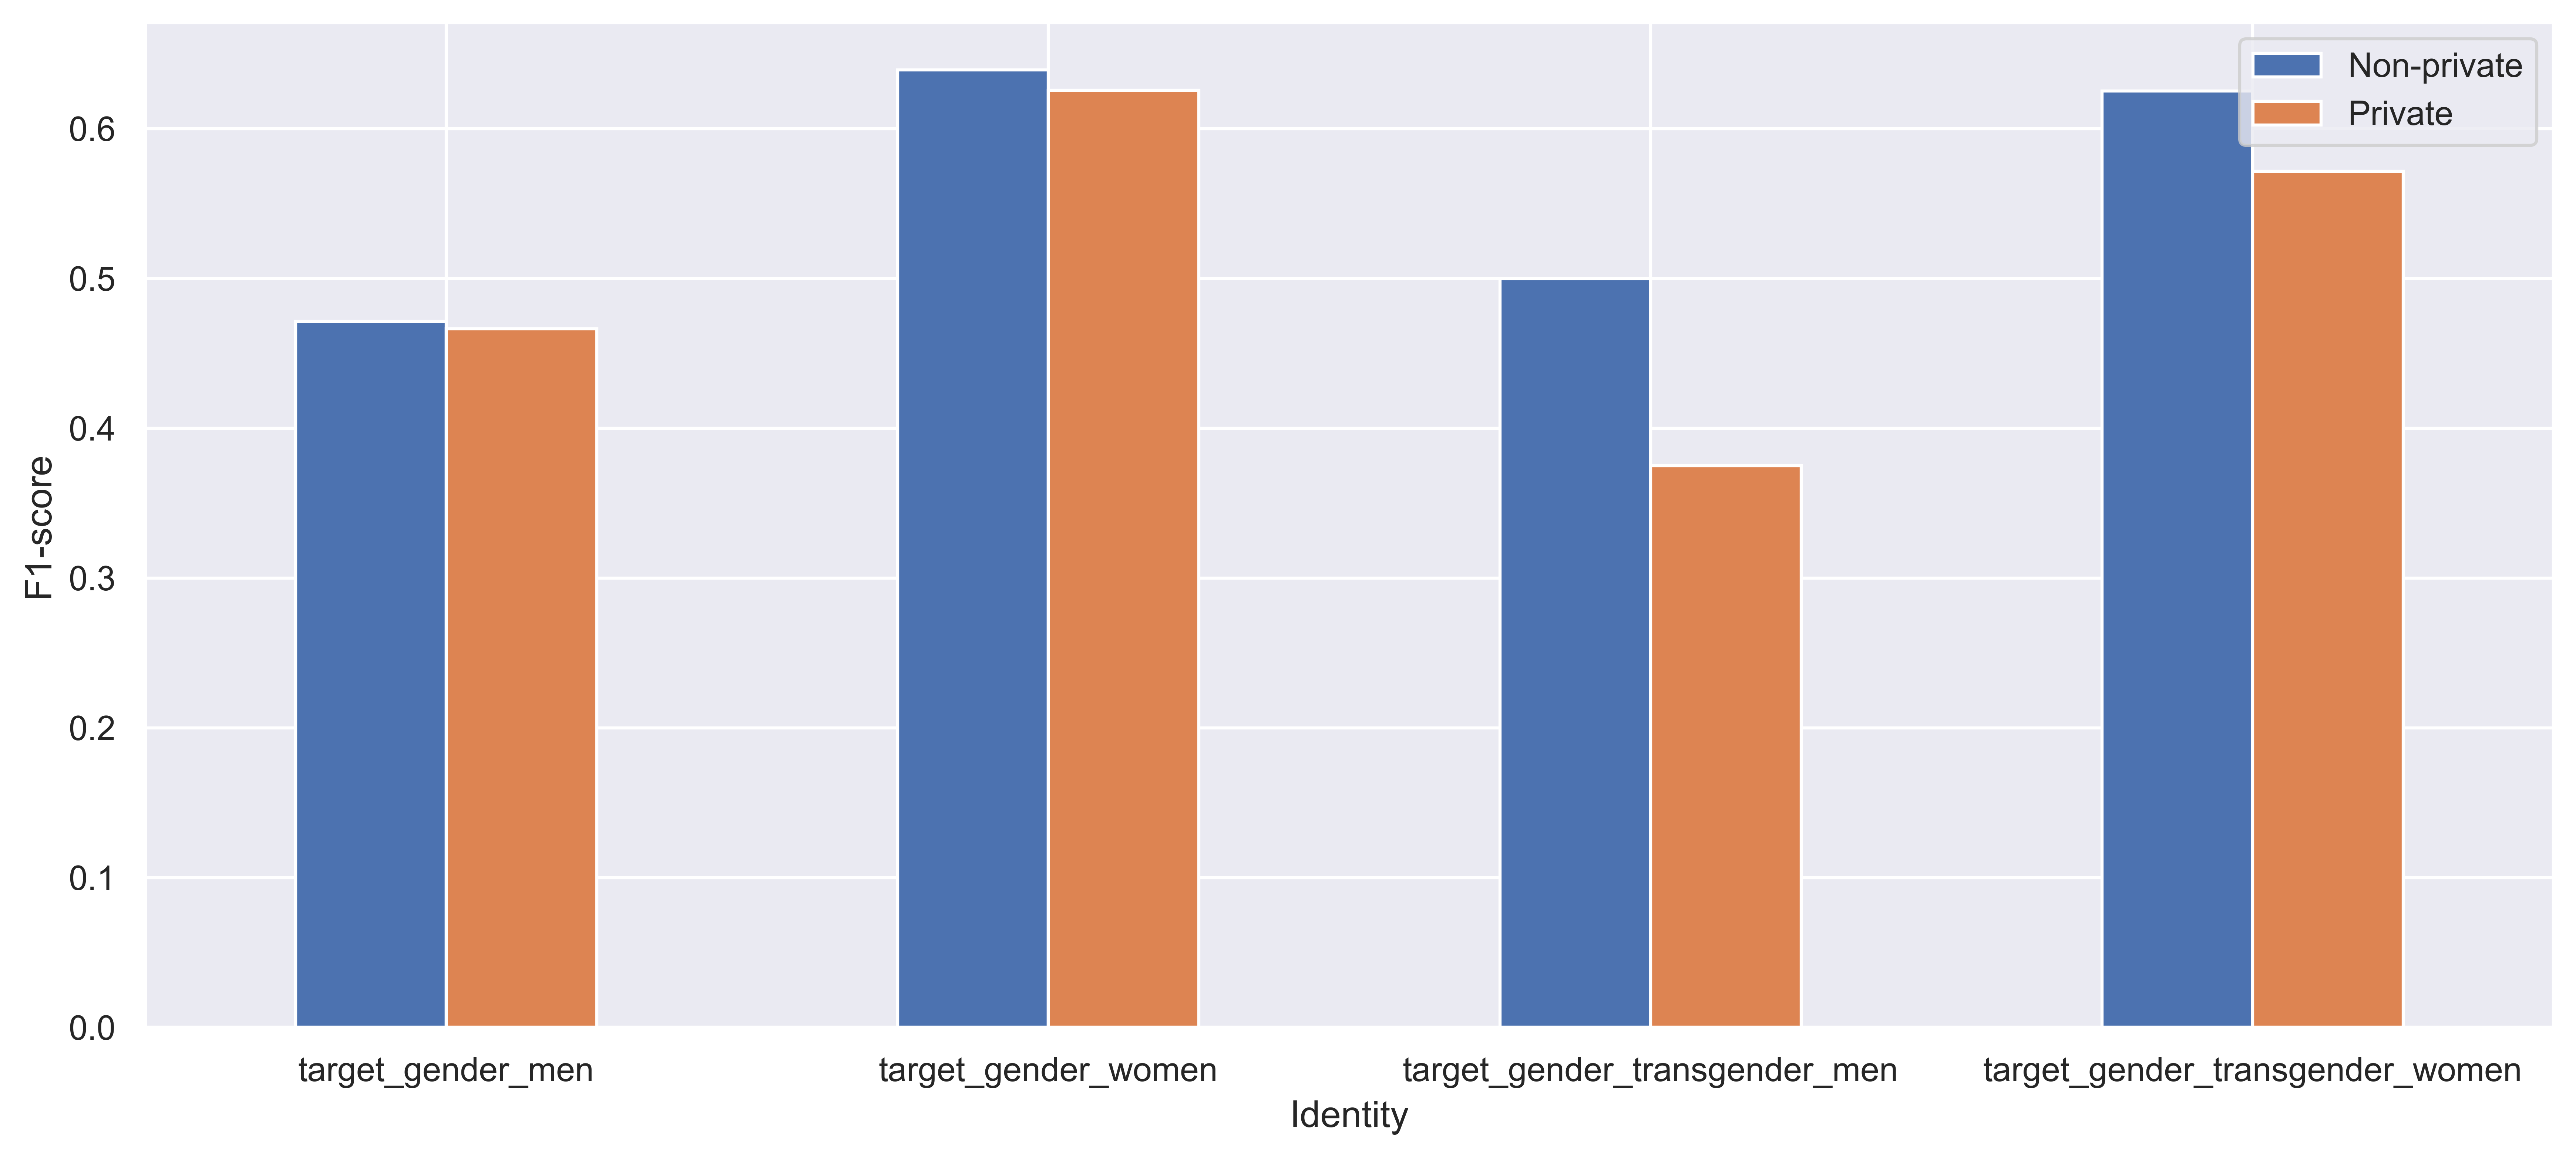

In [74]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_F1],
        'Private': test_dp_bias_metrics_df[SUBGROUP_F1]
    }
)

plot_metric(plot_df, "F1-score", subgroup_type,metric='F1')

## True Positive Score

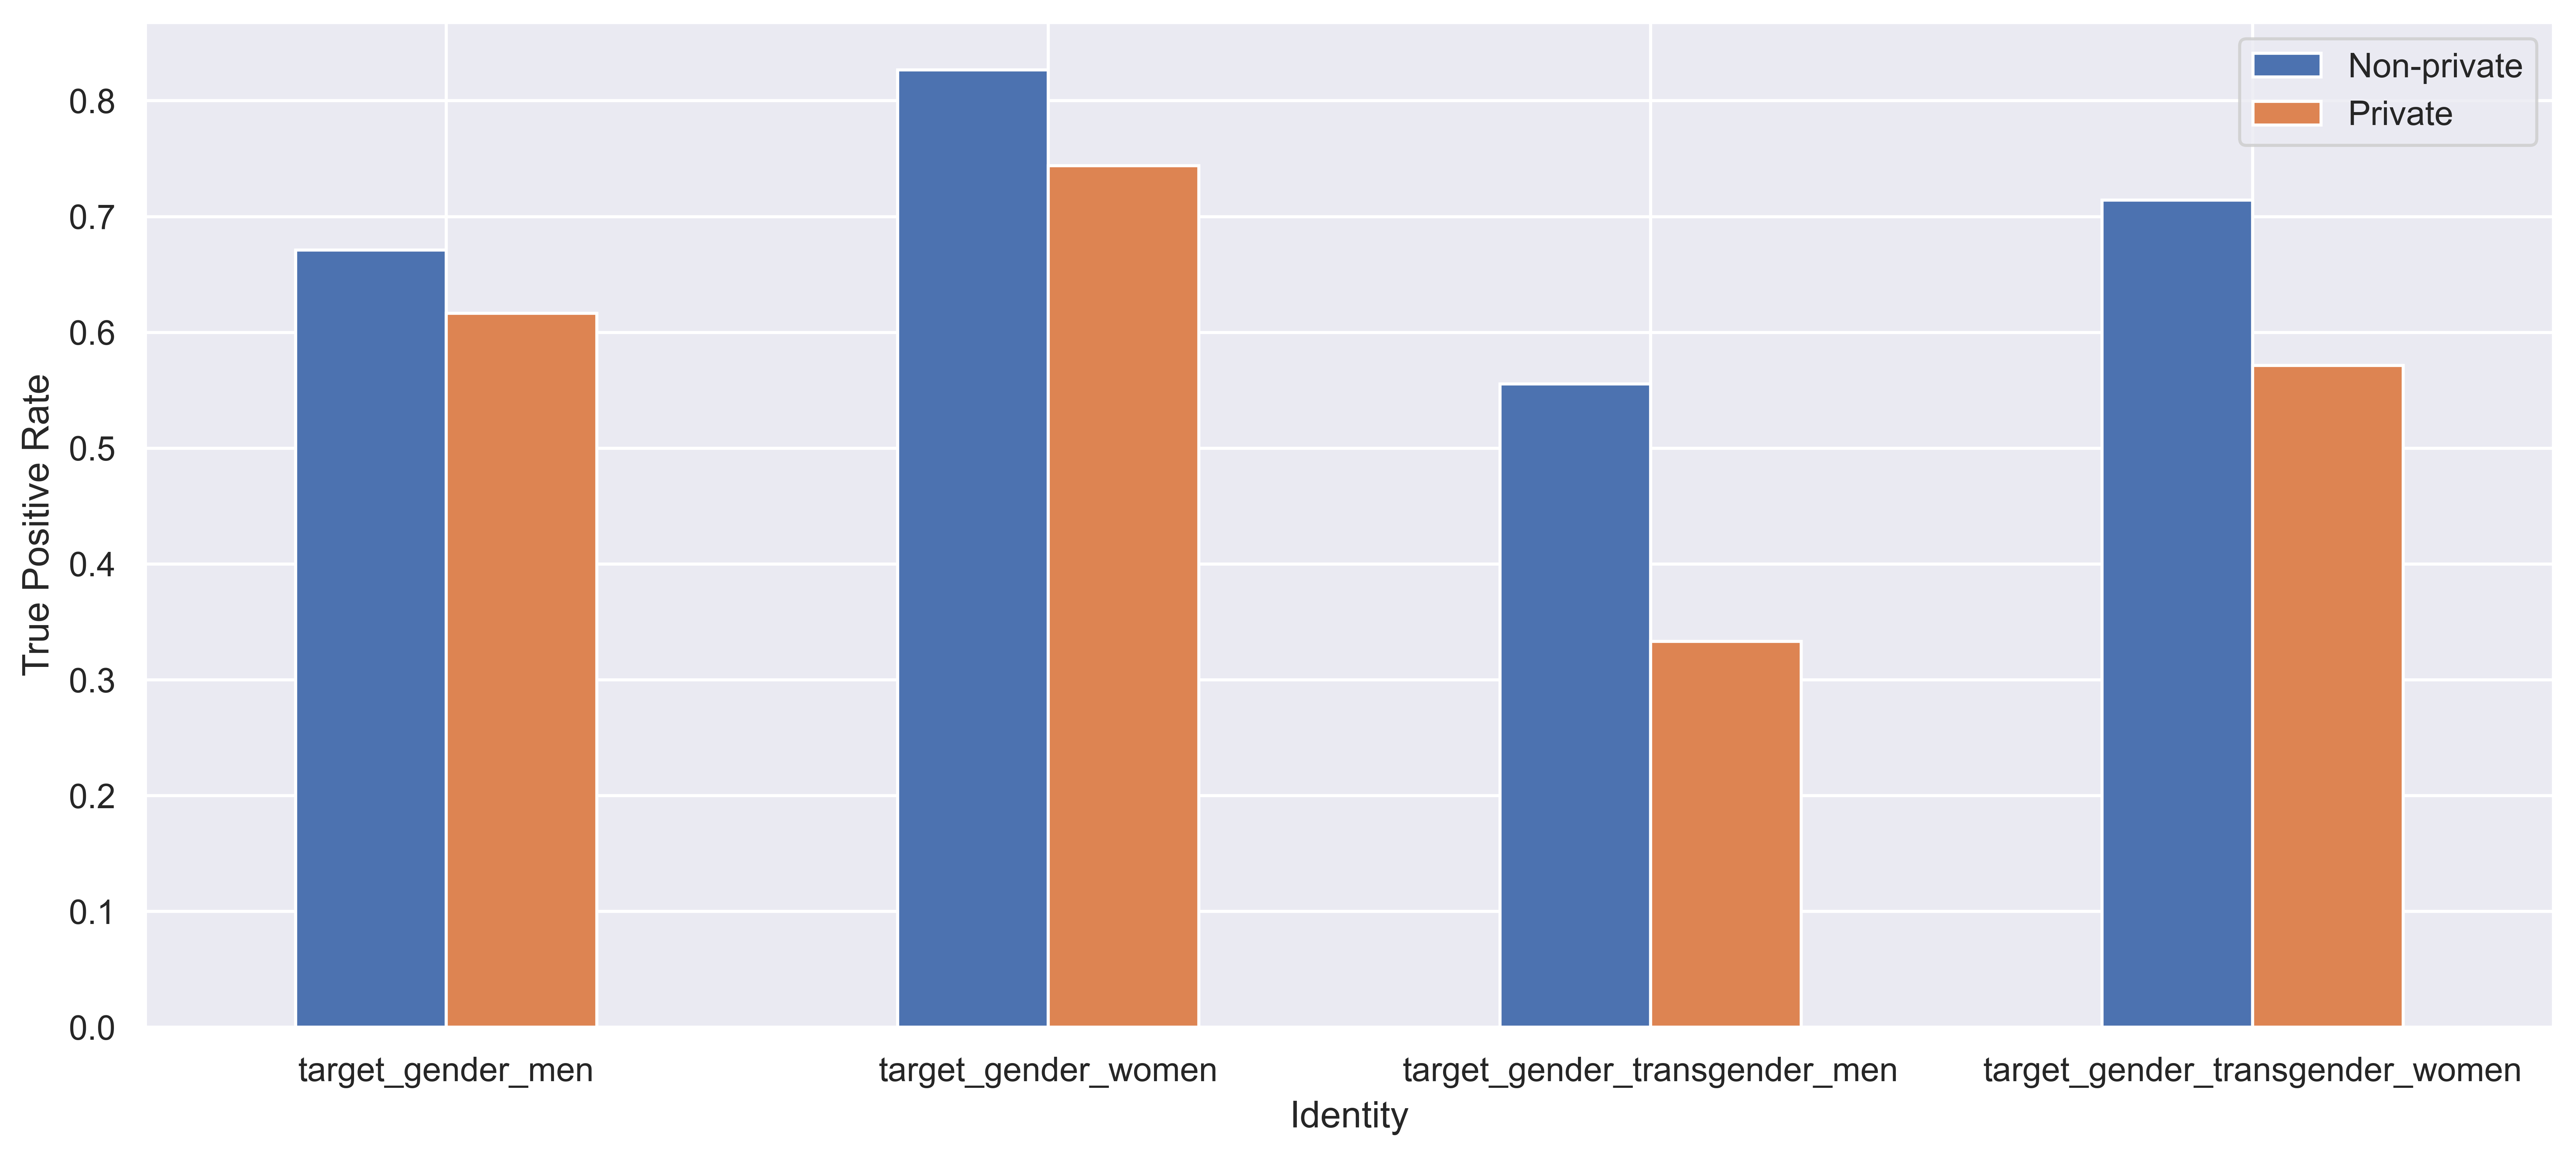

In [79]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_TPR],
        'Private': test_dp_bias_metrics_df[SUBGROUP_TPR]
    }
)

plot_metric(plot_df, "True Positive Rate", subgroup_type,metric='TPR')

## False Positive Rate

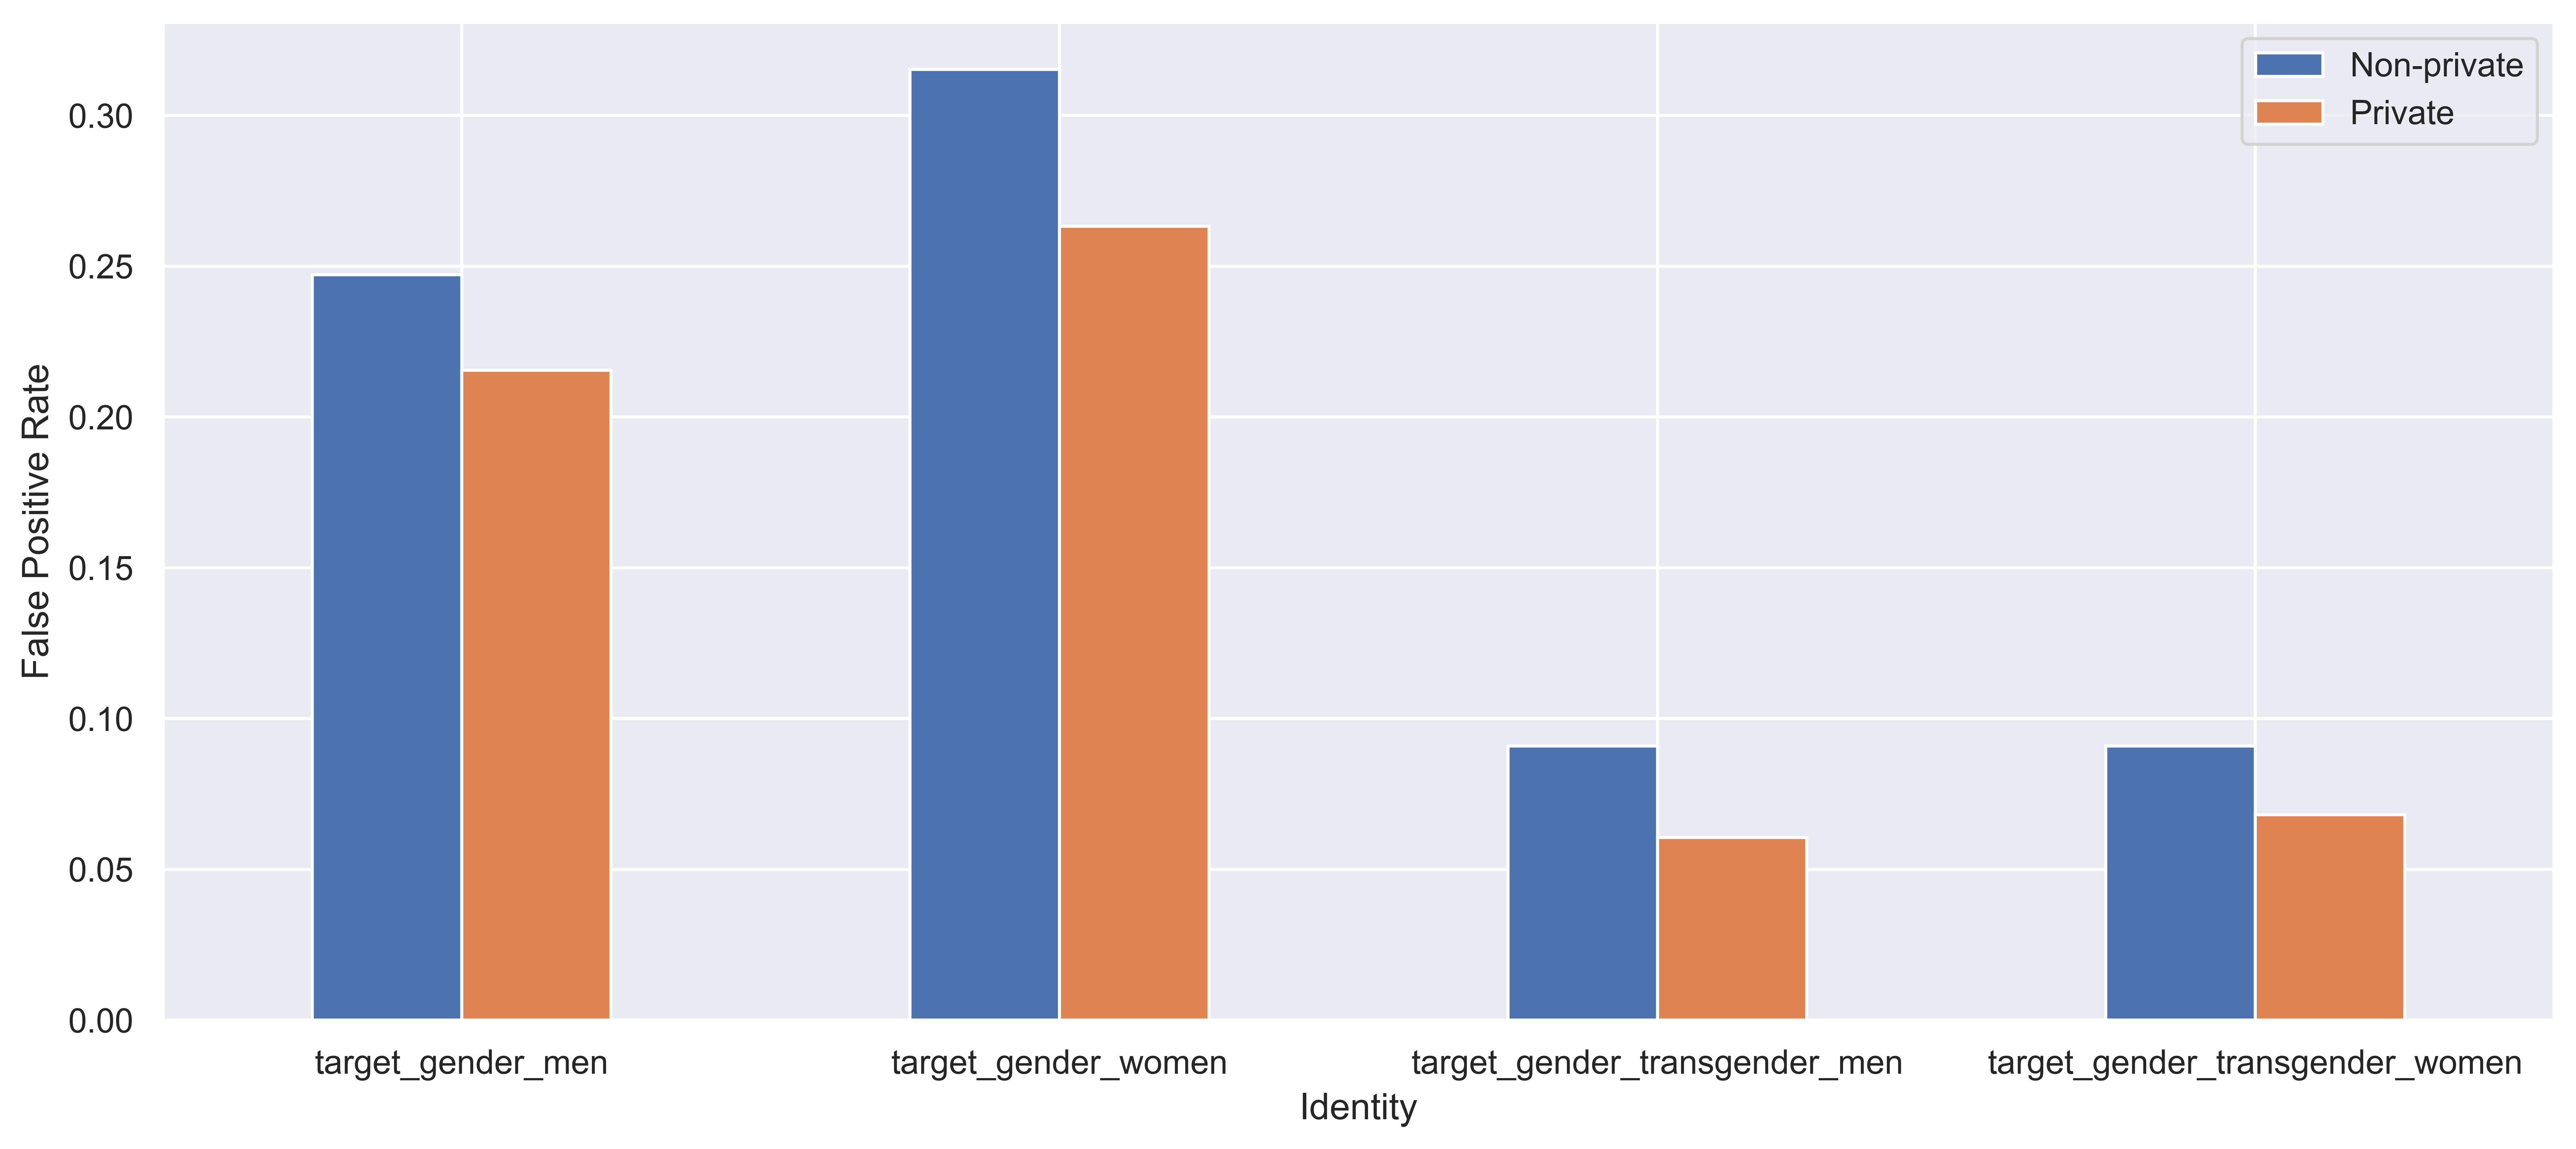

In [75]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_FPR],
        'Private': test_dp_bias_metrics_df[SUBGROUP_FPR]
    }
)

plot_metric(plot_df, "False Positive Rate", subgroup_type,metric='FPR')

## Accuracy

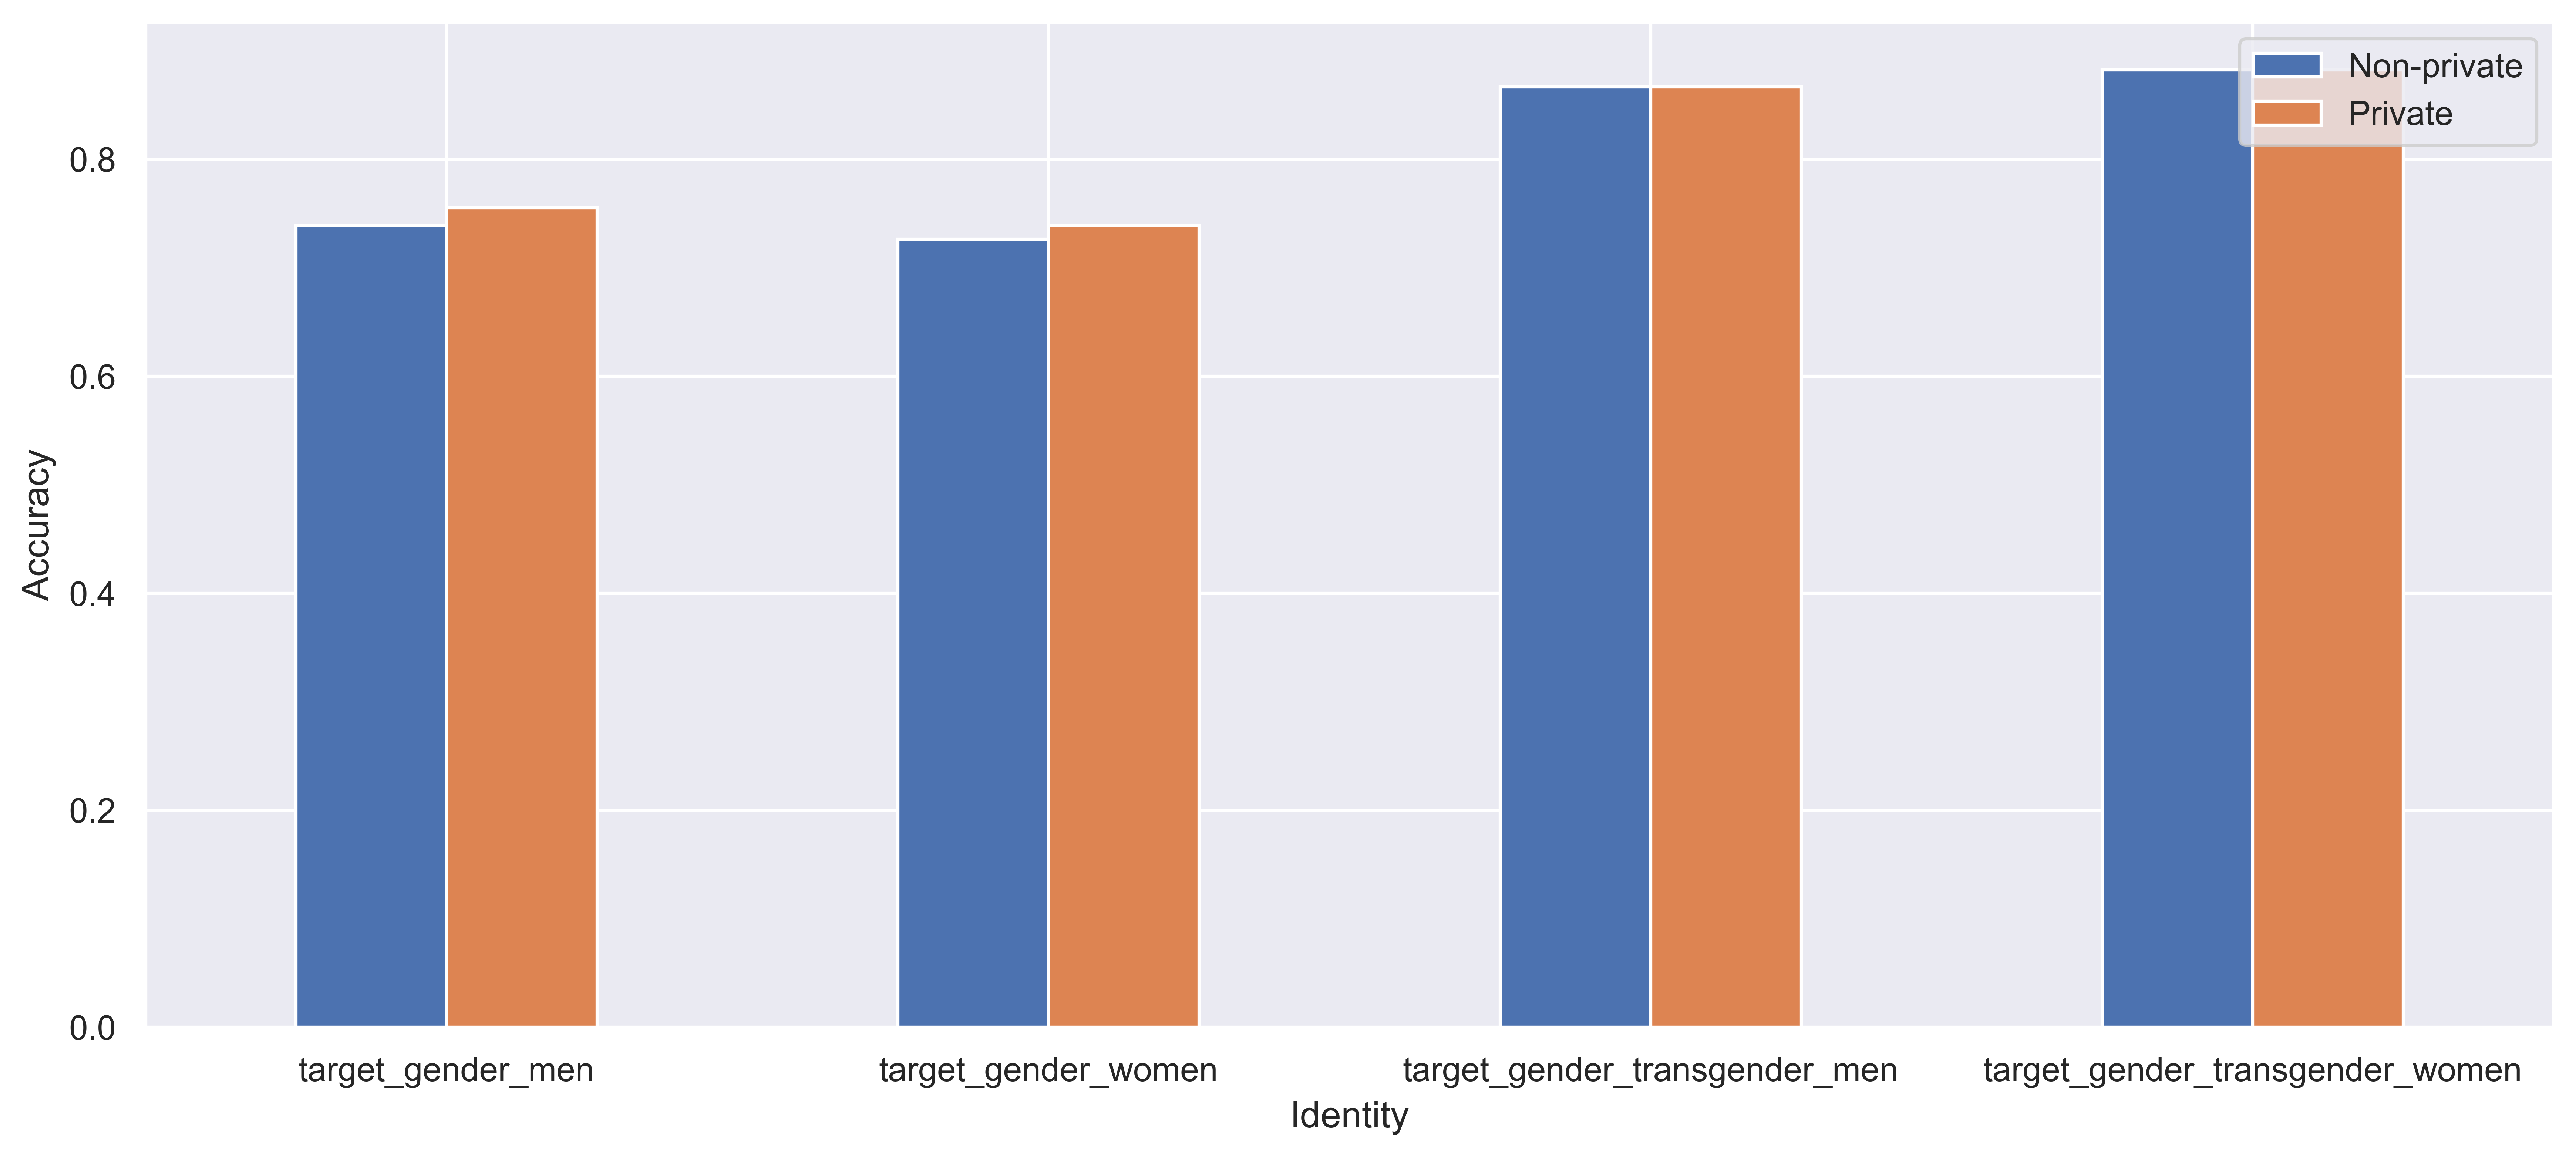

In [76]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_ACCURACY],
        'Private': test_dp_bias_metrics_df[SUBGROUP_ACCURACY]
    }
)
plot_metric(plot_df, "Accuracy", subgroup_type,metric='Accuracy')

## BPSN

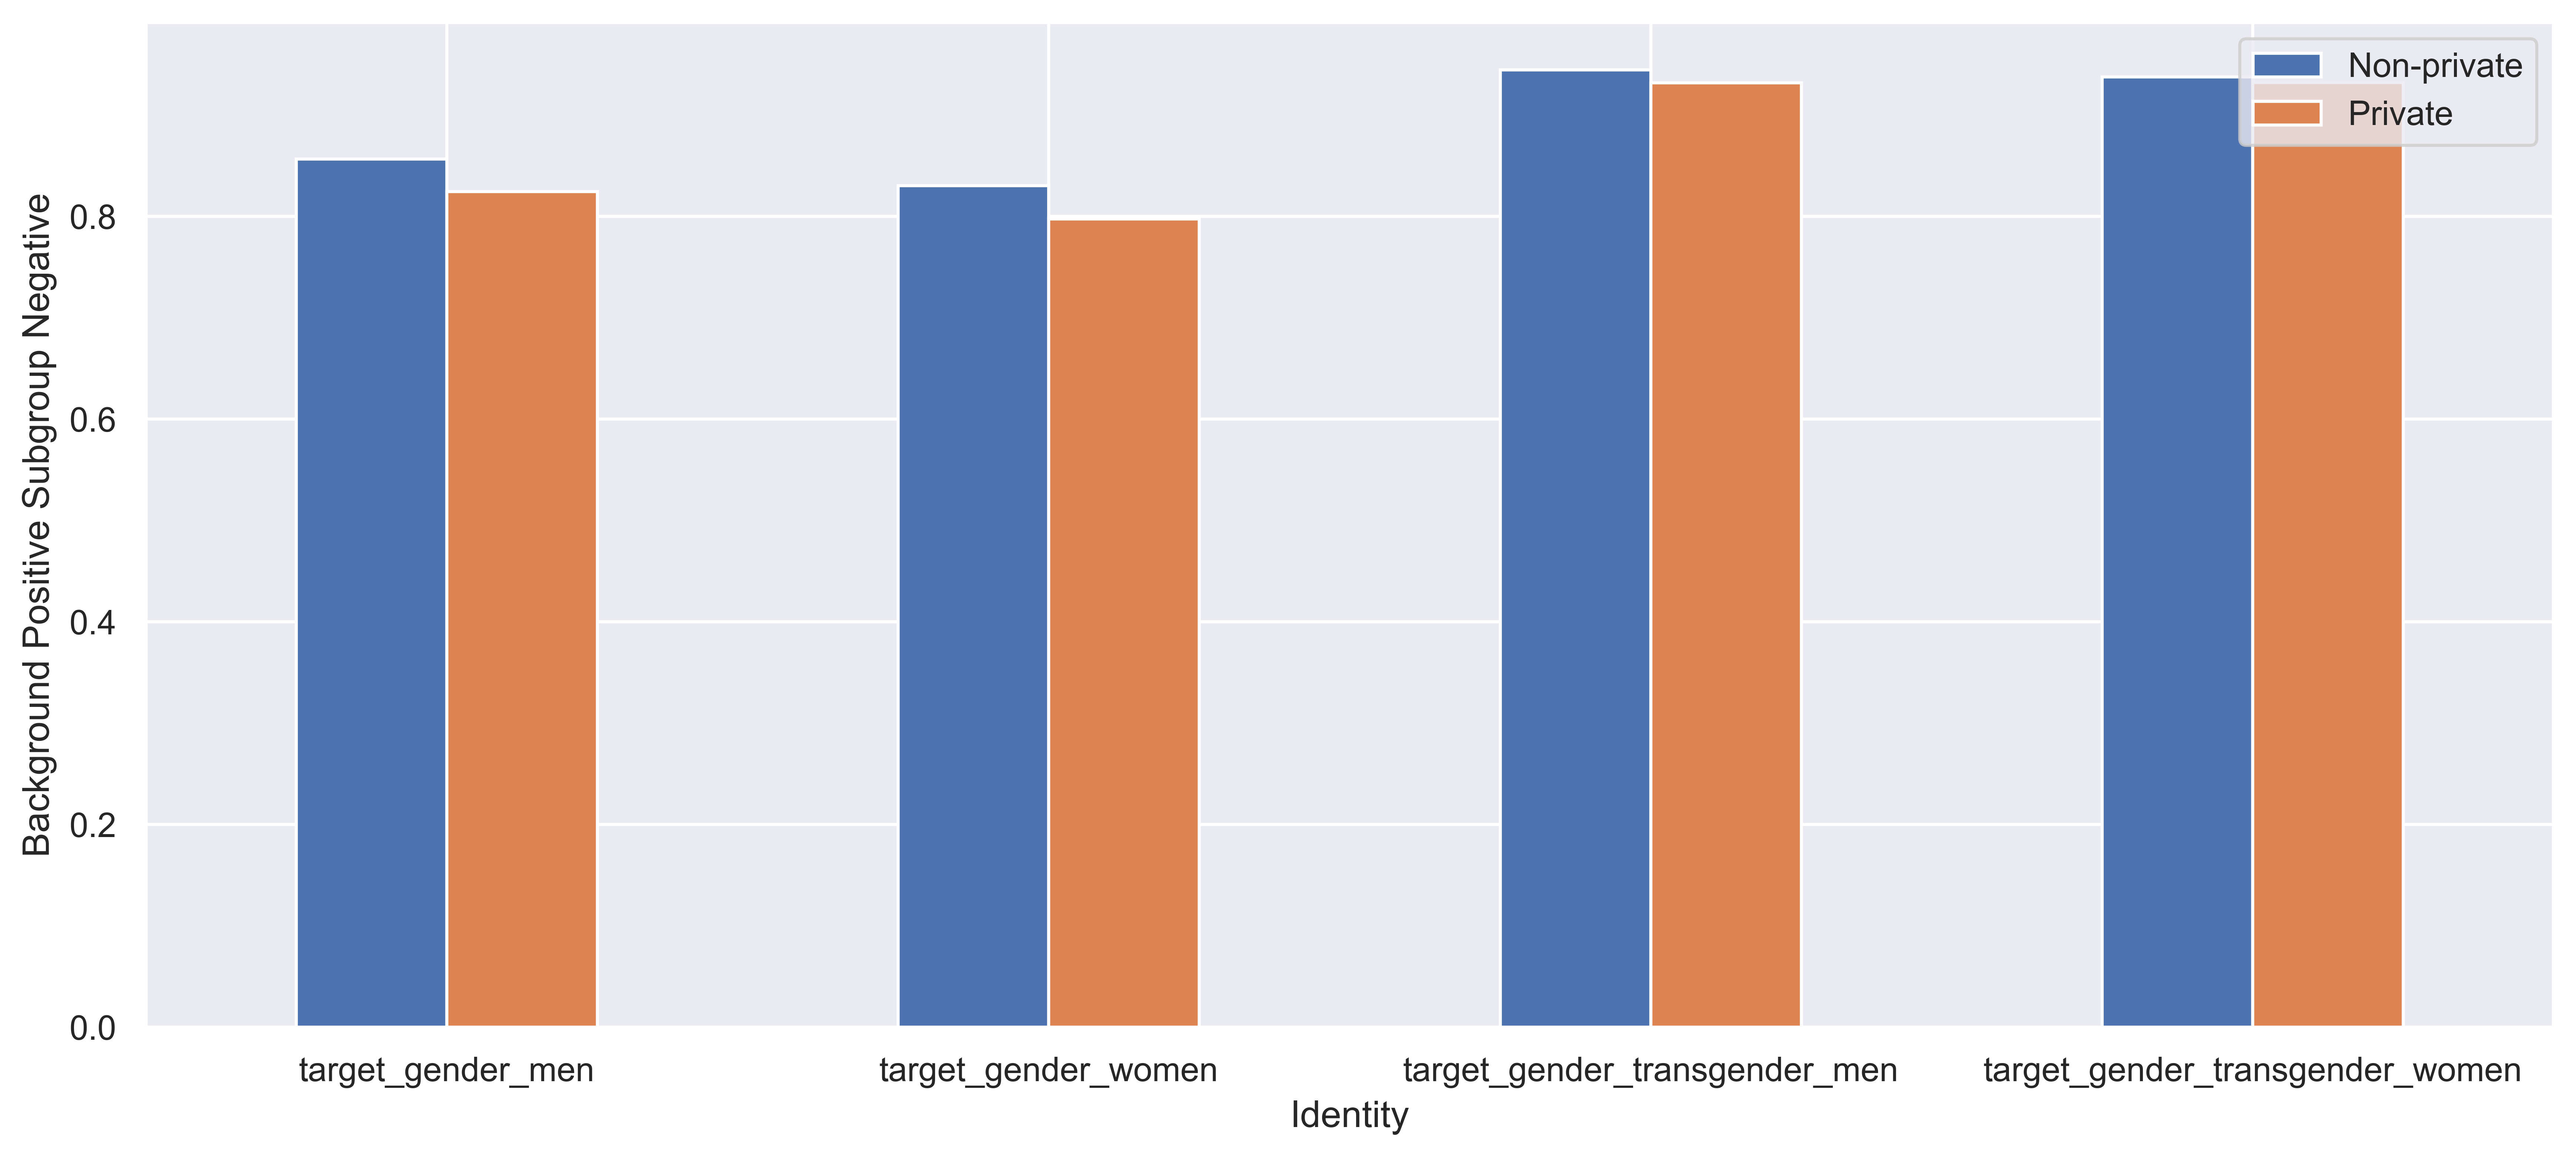

In [77]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[BPSN_AUC],
        'Private': test_dp_bias_metrics_df[BPSN_AUC]
    }
)
plot_metric(plot_df, "Background Positive Subgroup Negative", subgroup_type,metric='BPSN')

## BNSP

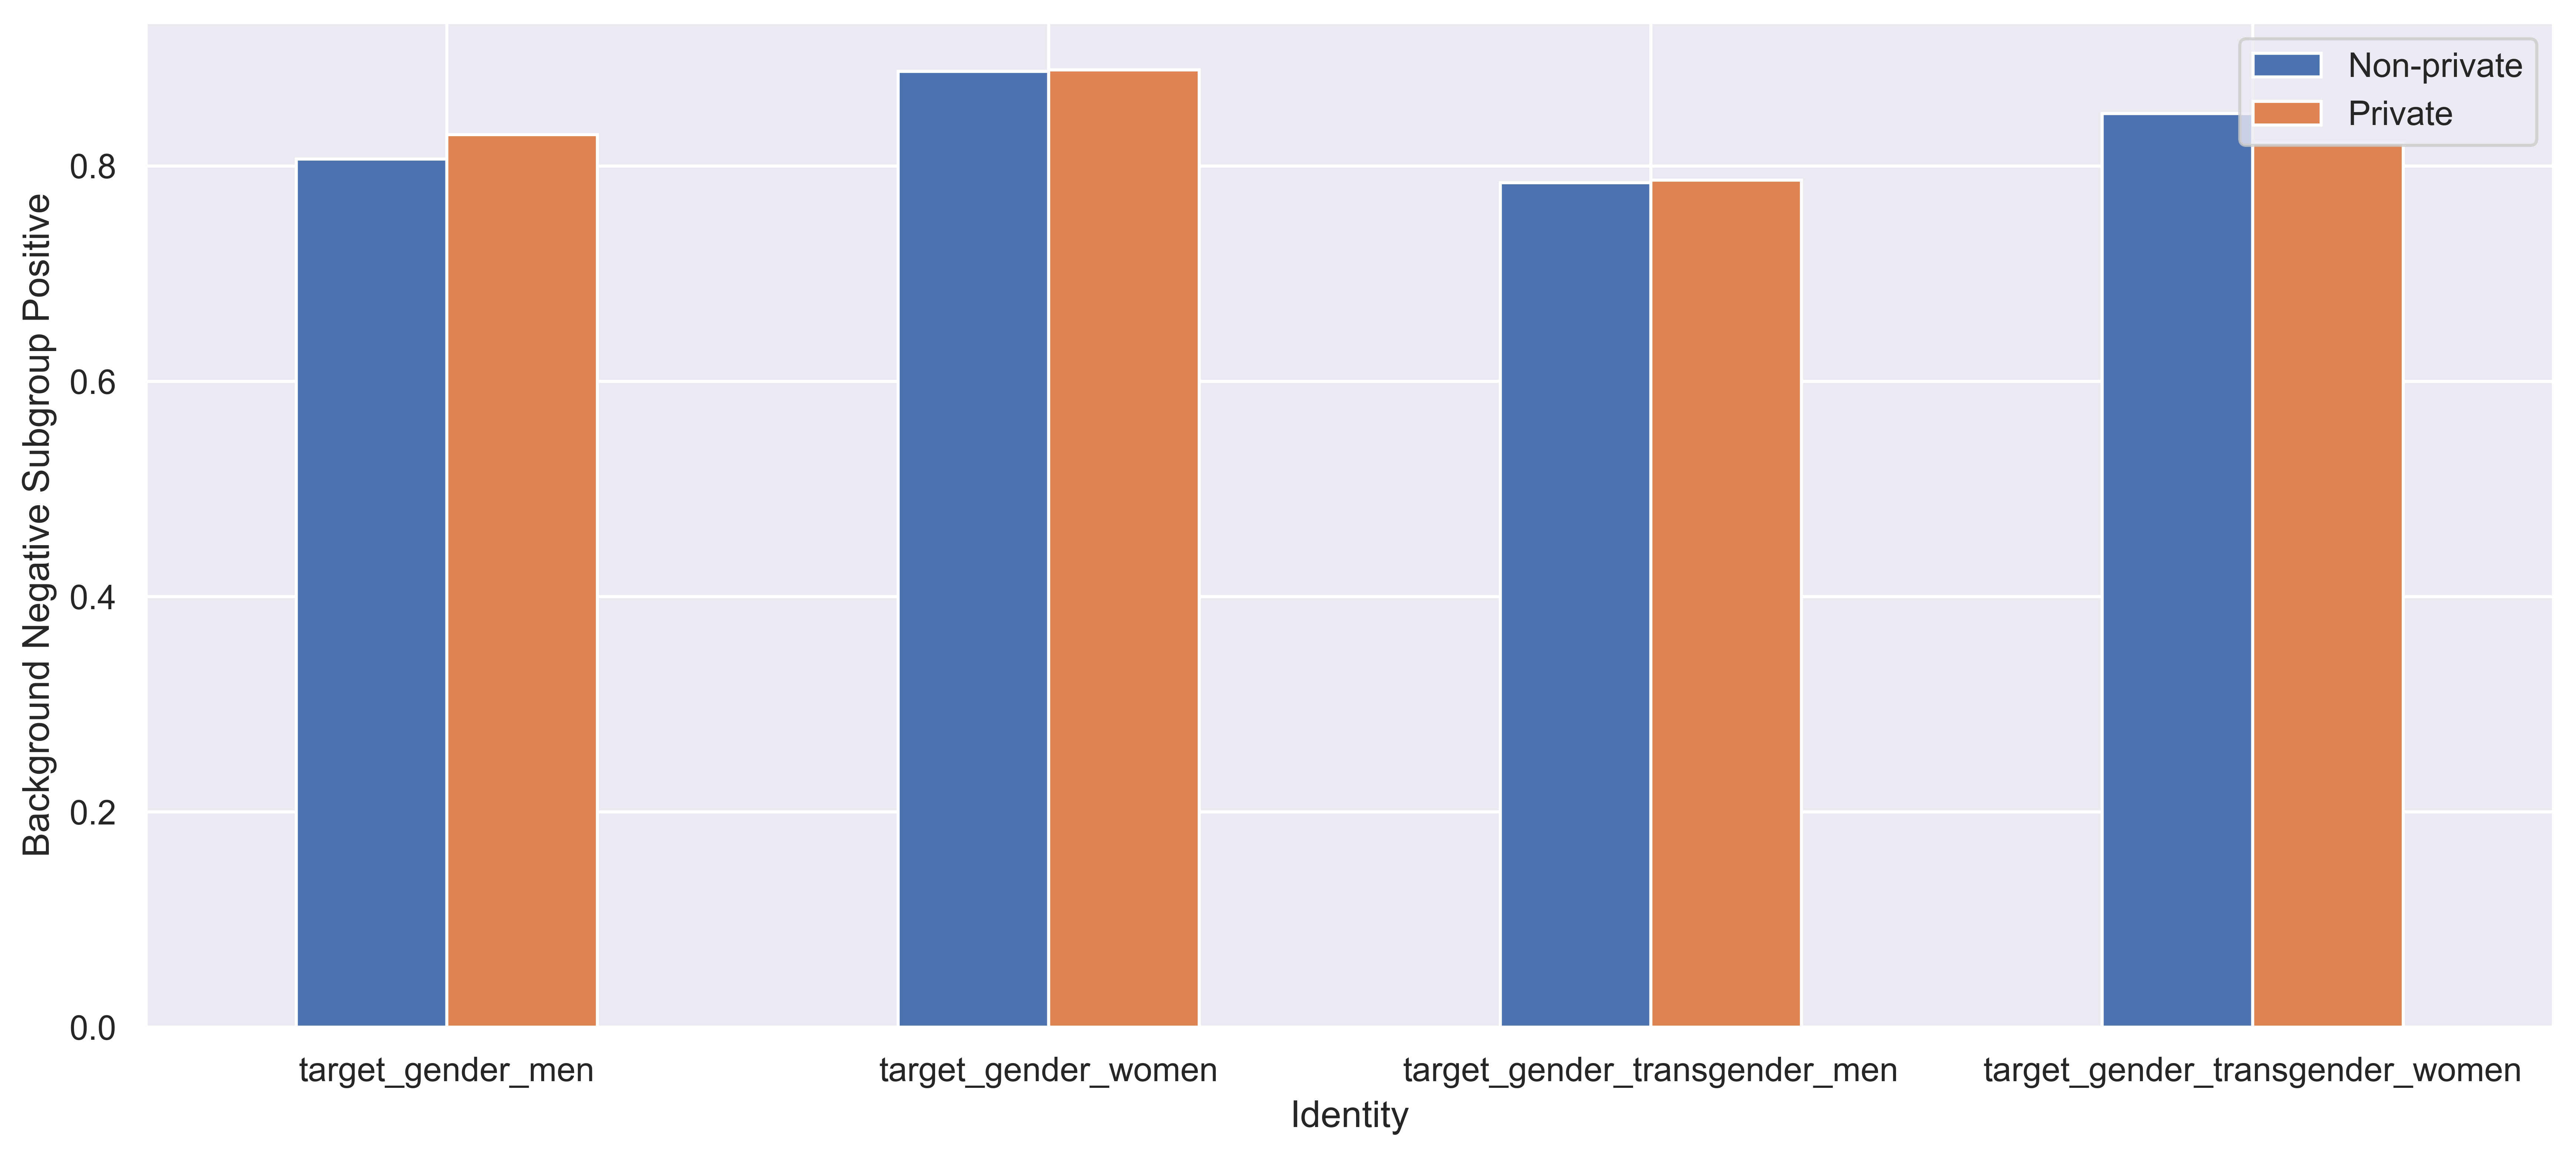

In [78]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[BNSP_AUC],
        'Private': test_dp_bias_metrics_df[BNSP_AUC]
    }
)
plot_metric(plot_df, "Background Negative Subgroup Positive", subgroup_type,metric='BNSP_AUC')